# Import Libraries

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt 
from tensorflow.keras.optimizers import Adam

# importing data directly from Yahoo Finance historical values

In [3]:


# Set a random seed to ensure that our results are reproducible.
# This means that every time you run your code, the random numbers generated (for example, during model initialization)
# will be the same, allowing you to consistently reproduce the same results.
np.random.seed(42)

# Define the stock ticker symbol for Tesla (TSLA)
ticker = 'GAP'

# Download historical stock data for Tesla for the past 5 years using yfinance.
# The yf.download() function retrieves various data fields (like Open, High, Low, Close, Volume) for the specified period.
data = yf.download(ticker, period='5y')

# Print the shape of the downloaded data to confirm its dimensions (number of rows and columns).
print("Data shape:", data.shape)

# Display the first few rows of the DataFrame to inspect the data and ensure it has been downloaded correctly.
data.head()

# We are interested in predicting the closing price of TSLA.
# Extract the 'Close' column from the DataFrame and reshape it to a two-dimensional array (required by many scikit-learn functions).
prices = data['Close'].values.reshape(-1, 1)

# Neural networks generally perform better when input data is scaled.
# Here, we create a MinMaxScaler to scale the closing prices so that all values fall within the range 0 to 1.
# This scaling helps the training process converge faster and more reliably.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data shape: (1257, 5)


In [4]:
# Define a function to create input sequences and corresponding targets from the time series data.
def create_sequences(data, window_size):
    """
    This function converts a time series into sequences of a fixed window size.
    Each sequence (X) consists of 'window_size' consecutive data points,
    and the target (y) is the data point immediately following that sequence.
    
    Parameters:
      - data: The scaled time series data (a 2D NumPy array).
      - window_size: The number of time steps to include in each input sequence.
      
    Returns:
      - X: NumPy array of input sequences.
      - y: NumPy array of targets corresponding to each sequence.
    """
    # Initialize empty lists to store sequences and targets.
    X = []  # List to hold input sequences
    y = []  # List to hold corresponding targets
    
    # Loop through the data, stopping at a point that allows a full sequence of the given window size
    for i in range(len(data) - window_size):
        # For each iteration, slice the data array to create a sequence of 'window_size' data points.
        # data[i:i+window_size, 0] extracts a sequence starting at index 'i' and spanning 'window_size' steps.
        X.append(data[i:i+window_size, 0])
        
        # The target value (y) is the data point immediately after the current sequence.
        y.append(data[i+window_size, 0])
        
    # Convert the lists of sequences and targets into NumPy arrays for efficient processing.
    return np.array(X), np.array(y)

# Set the window size to 60, meaning each input sequence will contain 60 consecutive time steps.
# For example, the model will use the data from the past 60 days to predict the next day's value.
window_size = 60

# Call the function to create sequences and targets from the scaled price data.
# 'scaled_prices' is our preprocessed dataset (with values scaled between 0 and 1).
X, y = create_sequences(scaled_prices, window_size)


# Pre-process Data

In [5]:
# Calculate the index to split the dataset into training and testing portions.
# We use 80% of the data for training and the remaining 20% for testing.
split = int(0.8 * len(X))

# Use array slicing to separate the input sequences and their corresponding targets:
# - X_train and y_train will contain the first 80% of the data.
# - X_test and y_test will contain the remaining 20%.
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Neural network models such as LSTM require input data to be in a specific 3-dimensional format:
# [samples, time steps, features]
# Currently, our data (X_train and X_test) is in a 2D shape (samples, time steps).
# We reshape it to add a third dimension representing the single feature per time step.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Print the shapes of the training and testing sets to confirm the dimensions.
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (957, 60, 1)
Test set shape: (240, 60, 1)


# Model 1 (Base Model)

In [6]:
# Build the Recurrent Neural Network (RNN) model using LSTM layers with the Sequential API.
# The model architecture is designed to process sequences of data and predict future values.

# Create a Sequential model where layers are added one after another.
model_1 = Sequential([
    # First LSTM layer with 50 units.
    # 'return_sequences=True' ensures that the full sequence of outputs is passed to the next layer,
    # which is necessary when stacking LSTM layers.
    # 'input_shape=(window_size, 1)' specifies the shape of the input data: 
    # 'window_size' time steps and 1 feature per time step.
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    
    # Dropout layer with a rate of 0.2.
    # This layer randomly sets 20% of the input units to 0 during training, which helps prevent overfitting.
    Dropout(0.2),
    
    # Second LSTM layer with 50 units.
    # 'return_sequences=False' means this layer outputs only the last value in the sequence,
    # which is appropriate for producing a final prediction.
    LSTM(50, return_sequences=False),
    
    # Another Dropout layer to further reduce overfitting by randomly dropping 20% of the neurons.
    Dropout(0.2),
    
    # A Dense (fully connected) layer with 25 neurons and a ReLU activation function.
    # This layer helps in learning complex patterns after the LSTM layers.
    Dense(25, activation='relu'),
    
    # The final Dense layer with 1 neuron to output the predicted value (e.g., the closing price).
    Dense(1)
])

# Compile the model with the Adam optimizer and mean squared error loss.
# Adam is chosen for its efficiency in handling noisy gradients,
# and mean squared error is a common loss function for regression tasks.
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary to show the architecture and the number of parameters at each layer.
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-traina

# Train the model

In [ ]:
# Setup Early Stopping to prevent overfitting.
# EarlyStopping monitors the validation loss during training.
# If the validation loss does not improve for 10 consecutive epochs ('patience'=10),
# training will stop, and the best weights encountered during training will be restored.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the training data.
# Here, we specify:
# - 'epochs=50': The maximum number of training iterations over the entire dataset.
# - 'batch_size=32': The number of samples processed before updating the model's weights.
# - 'validation_split=0.1': 10% of the training data is set aside for validating the model during training.
# - 'callbacks=[early_stop]': This list includes our EarlyStopping callback.
# - 'verbose=1': This setting enables progress messages during training.
history = model_1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
27/27 [==============================] - 5s 64ms/step - loss: 0.0505 - val_loss: 0.0108
Epoch 2/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 3/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0046 - val_loss: 0.0071
Epoch 4/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 5/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 6/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 7/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 0.0061
Epoch 8/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 9/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 10/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 11/

# Visual - require explanation and based on those reshape the model

8/8 [==============================] - 1s 10ms/step - loss: 0.0024
Test Loss: 0.0024145503994077444
8/8 [==============================] - 1s 10ms/step


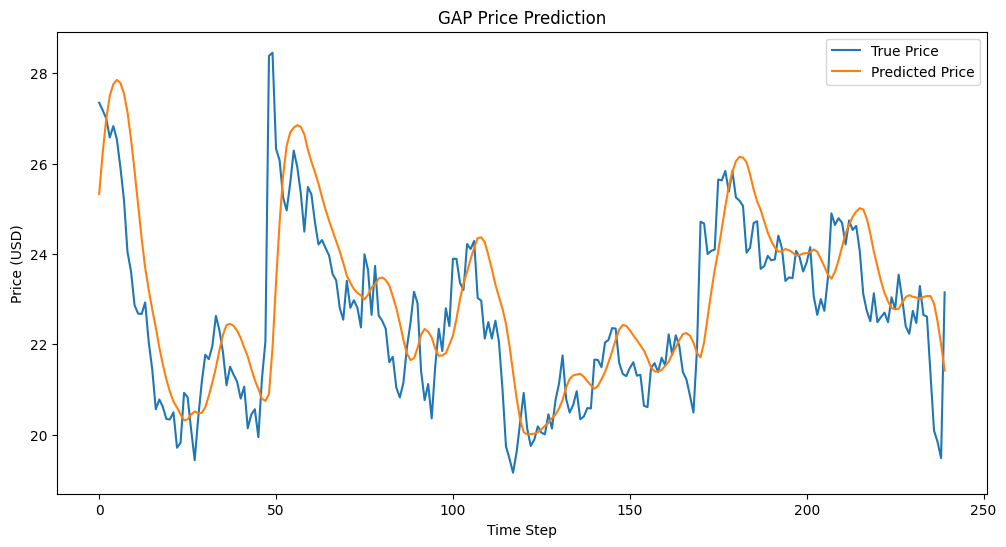

In [ ]:
# Evaluate model performance on test set
loss = model_1.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions on the test set
predictions = model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='True Price')
plt.plot(predictions, label='Predicted Price')
plt.title('GAP Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## The model has too much lag, and it is unable to capture detail price fluctuation. Although its general pattern matches the data. 

# Loss Function

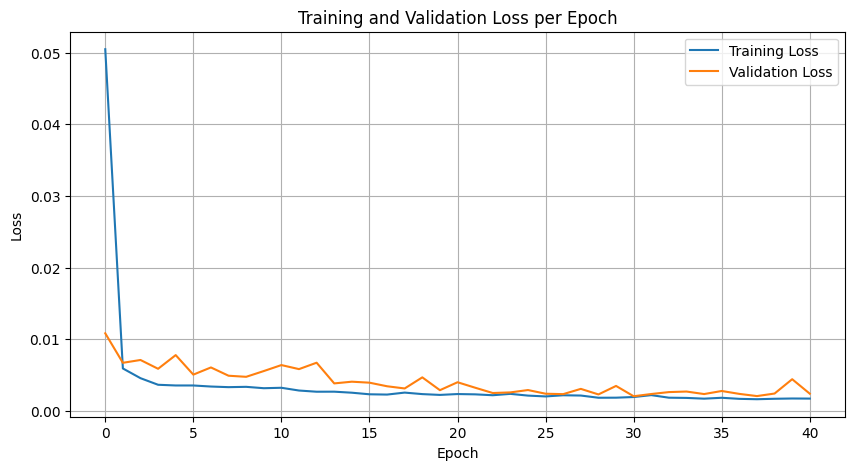

In [9]:
import matplotlib.pyplot as plt

# Plot the training and validation loss values from the history object
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## The loss functions remains higher than the training loss, with steady fluctuations

# Predicting 30 days in the future

In [10]:
# Number of future days to predict (e.g., one month = 30 days)
future_steps = 30

# Start with the last 'window_size' days from our scaled data as the initial input sequence.
# We use the entire dataset's last sequence, but you could also use the last sequence from the test set.
last_sequence = scaled_prices[-window_size:].copy()

# Initialize an empty list to store our future predictions.
future_predictions = []

# Iteratively predict one day at a time and update the sequence for the next prediction.
for _ in range(future_steps):
    # Reshape the current sequence to match the input shape expected by the LSTM: [samples, time steps, features]
    input_seq = last_sequence.reshape(1, window_size, 1)
    
    # Predict the next value using the trained model.
    next_value_scaled = model_1.predict(input_seq)[0][0]
    
    # Append the predicted value to our list of future predictions.
    future_predictions.append(next_value_scaled)
    
    # Update the sequence by removing the first value and appending the new prediction at the end.
    last_sequence = np.append(last_sequence[1:], [[next_value_scaled]], axis=0)

# Inverse transform the scaled predictions back to the original price range.
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print the future predictions
print("Predicted future values for the next 30 days:")
print(future_predictions_unscaled)


1/1 [==============================] - 0s 19ms/step
Predicted future values for the next 30 days:
[[21.29389 ]
 [21.235332]
 [21.231325]
 [21.263842]
 [21.321056]
 [21.39528 ]
 [21.481432]
 [21.576075]
 [21.676836]
 [21.782038]
 [21.89044 ]
 [22.001122]
 [22.113369]
 [22.226643]
 [22.340506]
 [22.45463 ]
 [22.568754]
 [22.682674]
 [22.796246]
 [22.909351]
 [23.0219  ]
 [23.133837]
 [23.245125]
 [23.355726]
 [23.465626]
 [23.574825]
 [23.6833  ]
 [23.791065]
 [23.898115]
 [24.00445 ]]


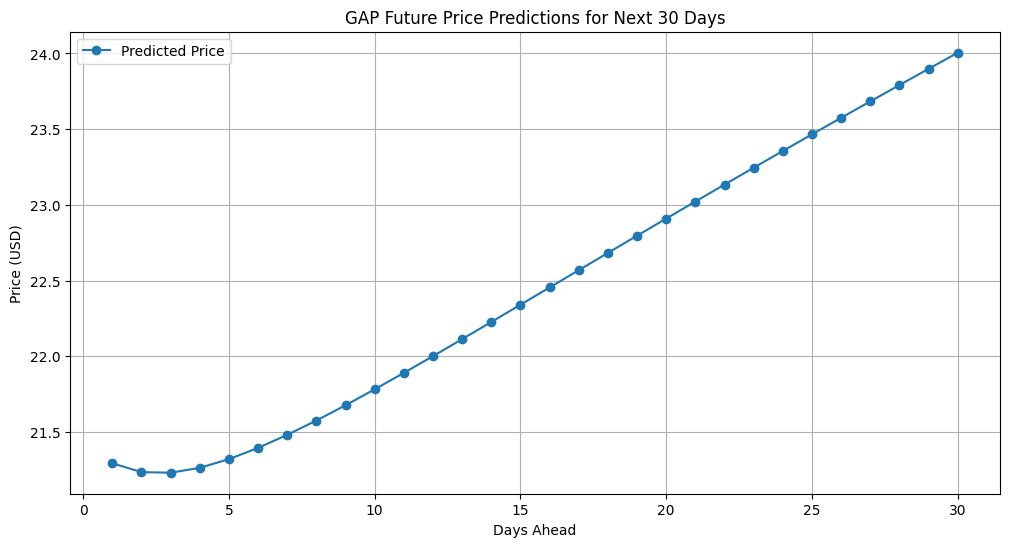

In [11]:
import matplotlib.pyplot as plt

# Create an array for the x-axis representing each future day (1 to future_steps)
future_days = np.arange(1, future_steps + 1)

# Plot the predicted future values
plt.figure(figsize=(12, 6))
plt.plot(future_days, future_predictions_unscaled, marker='o', linestyle='-', label='Predicted Price')
plt.title("GAP Future Price Predictions for Next 30 Days")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# Code for cross validation

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define a function that creates a new instance of the RNN model
def create_model(window_size):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up TimeSeriesSplit for cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# List to store validation loss for each fold
val_losses = []

# Loop through each split of the training data
for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Training fold {fold+1}")
    
    # Split the data into current fold's training and validation sets
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Create a new model instance for each fold
    model_cv = create_model(window_size)
    
    # Setup EarlyStopping to monitor validation loss for the current fold
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model on the current fold's training data
    history_cv = model_cv.fit(
        X_train_cv, y_train_cv,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[early_stop],
        verbose=0  # Set verbose to 0 to reduce output clutter; change to 1 for more details
    )
    
    # Evaluate the model on the current fold's validation data
    fold_val_loss = model_cv.evaluate(X_val_cv, y_val_cv, verbose=0)
    print(f"Fold {fold+1} Validation Loss: {fold_val_loss}")
    val_losses.append(fold_val_loss)

# Calculate the average validation loss across all folds
average_val_loss = np.mean(val_losses)
print("Cross-validation validation losses:", val_losses)
print("Average validation loss:", average_val_loss)


Training fold 1
Fold 1 Validation Loss: 0.004960354417562485
Training fold 2
Fold 2 Validation Loss: 0.0028560177888721228
Training fold 3
Fold 3 Validation Loss: 0.0012077119899913669
Training fold 4
Fold 4 Validation Loss: 0.0005649770027957857
Training fold 5
Fold 5 Validation Loss: 0.003569698194041848
Cross-validation validation losses: [0.004960354417562485, 0.0028560177888721228, 0.0012077119899913669, 0.0005649770027957857, 0.003569698194041848]
Average validation loss: 0.0026317518786527216


# Other choices for optimizers
While Adam is a strong default choice, you might experiment with alternatives such as RMSprop 
or even SGD with momentum if you encounter specific issues during training. 

# Model 2 (Hyper-tuned)

In [13]:
def build_hp_model(hp):
    LSTM_model = Sequential([
        # 1st LSTM layer (tuning between 32, 50, 64, 128 nodes)
        LSTM(units = hp.Choice('lstm_units_1', values = [32, 50, 64, 128]), return_sequences=True, input_shape=(window_size, 1)),

        # dropout layer tuning
        Dropout(hp.Choice('dropout_rate_1', values = [0.1, 0.2, 0.3])),

        # 2nd LSTM layer (tuning between 32, 50, 64, 128 nodes)
        LSTM(units = hp.Choice('lstm_units_2', values = [32, 50, 64, 128]), return_sequences=False),

        # dropout layer tuning
        Dropout(hp.Choice('dropout_rate_2', values = [0.1, 0.2, 0.3])),

        # Dense layer
        Dense(hp.Choice('dense_units', values = [16, 25, 32]), activation='relu'),

        # Output layer
        Dense(1)
    ])

    LSTM_model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                       loss = 'mean_squared_error')

    return LSTM_model

# Define the tuner
tuner = kt.RandomSearch(
    build_hp_model,
    objective='val_loss',
    max_trials=10,  
    executions_per_trial=1, 
    directory='RNN_LSTM_model2_tuning',
    project_name='lstm_stock_forecasting'
)

# Start tuning
tuner.search(X_train, y_train, 
             epochs=50, 
             batch_size = 32,
             validation_split=0.1, 
             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], 
             verbose=1
)

# get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'''
Best hyperparameters:
LSTM Units Layer 1: {best_hps.get('lstm_units_1')}
LSTM Units Layer 2: {best_hps.get('lstm_units_2')}
Dropout Rate 1: {best_hps.get('dropout_rate_1')}    
Dropout Rate 2: {best_hps.get('dropout_rate_2')}  
Dense Layer: {best_hps.get('dense_units')}    
Learning Rate: {best_hps.get('learning_rate')}
      ''')

Trial 10 Complete [00h 01m 34s]
val_loss: 0.0008269145037047565

Best val_loss So Far: 0.0006883835303597152
Total elapsed time: 00h 13m 18s

Best hyperparameters:
LSTM Units Layer 1: 32
LSTM Units Layer 2: 32
Dropout Rate 1: 0.1    
Dropout Rate 2: 0.1  
Dense Layer: 16    
Learning Rate: 0.01
      


In [14]:
# Rebuild and train the best model
model_2 = tuner.hypermodel.build(best_hps)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 32)            4352      
                                                                 
 dropout_2 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,217
Trainable params: 13,217
Non-trai

# Train the model

In [15]:
# training 
history = model_2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
27/27 [==============================] - 5s 54ms/step - loss: 0.0200 - val_loss: 0.0034
Epoch 2/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 3/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 4/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 5/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 8/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 9/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 10/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11/

# Visual

8/8 [==============================] - 1s 8ms/step - loss: 0.0013
Test Loss: 0.0013375221751630306
8/8 [==============================] - 1s 8ms/step


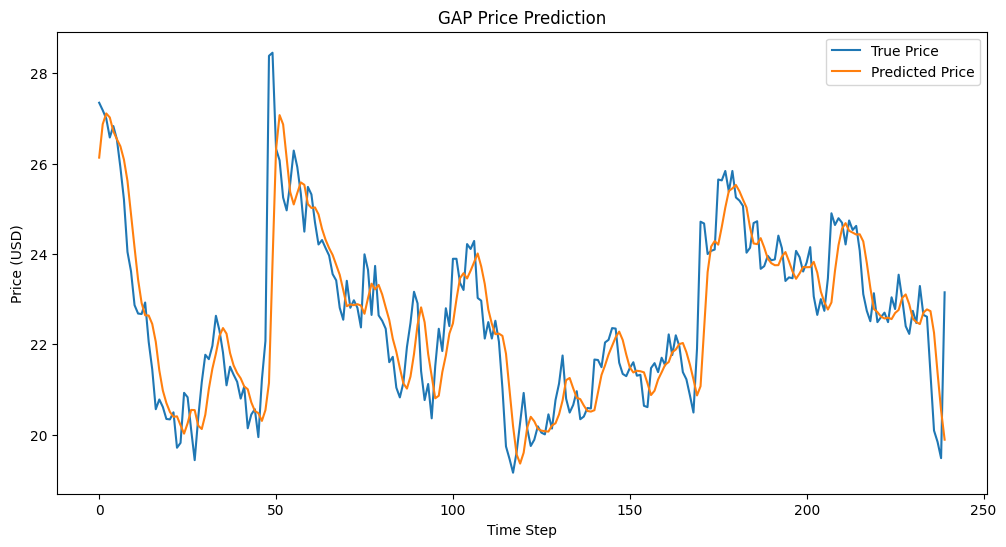

In [16]:
# Evaluate model performance on test set
loss = model_2.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions on the test set
predictions = model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='True Price')
plt.plot(predictions, label='Predicted Price')
plt.title('GAP Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Model 2 has significant less lag, and the pattern seems to be more detailed and aligns well with the actual data

# Loss Function

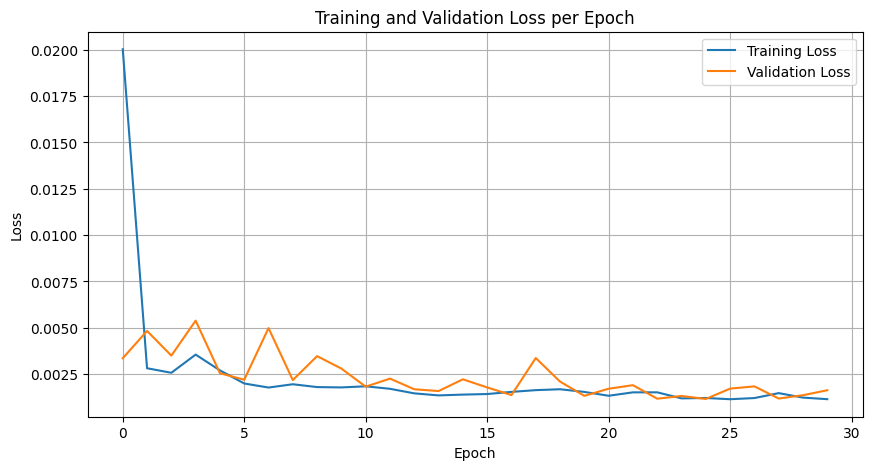

In [17]:
import matplotlib.pyplot as plt

# Plot the training and validation loss values from the history object
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## The loss function fluctuates a lot at the beginning and is able to stablize and eventually catch up to the training loss

# Predicting 30 days in the future

In [18]:
# Number of future days to predict (e.g., one month = 30 days)
future_steps = 30

# Start with the last 'window_size' days from our scaled data as the initial input sequence.
# We use the entire dataset's last sequence, but you could also use the last sequence from the test set.
last_sequence = scaled_prices[-window_size:].copy()

# Initialize an empty list to store our future predictions.
future_predictions = []

# Iteratively predict one day at a time and update the sequence for the next prediction.
for _ in range(future_steps):
    # Reshape the current sequence to match the input shape expected by the LSTM: [samples, time steps, features]
    input_seq = last_sequence.reshape(1, window_size, 1)
    
    # Predict the next value using the trained model.
    next_value_scaled = model_2.predict(input_seq)[0][0]
    
    # Append the predicted value to our list of future predictions.
    future_predictions.append(next_value_scaled)
    
    # Update the sequence by removing the first value and appending the new prediction at the end.
    last_sequence = np.append(last_sequence[1:], [[next_value_scaled]], axis=0)

# Inverse transform the scaled predictions back to the original price range.
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print the future predictions
print("Predicted future values for the next 30 days:")
print(future_predictions_unscaled)

1/1 [==============================] - 0s 20ms/step
Predicted future values for the next 30 days:
[[20.707367]
 [21.06959 ]
 [21.229553]
 [21.289854]
 [21.309814]
 [21.317228]
 [21.322645]
 [21.328821]
 [21.335756]
 [21.342875]
 [21.34973 ]
 [21.35615 ]
 [21.362118]
 [21.367708]
 [21.373009]
 [21.378103]
 [21.383041]
 [21.387865]
 [21.392595]
 [21.397245]
 [21.40182 ]
 [21.406326]
 [21.410759]
 [21.415121]
 [21.419415]
 [21.423635]
 [21.42779 ]
 [21.43187 ]
 [21.435883]
 [21.439825]]


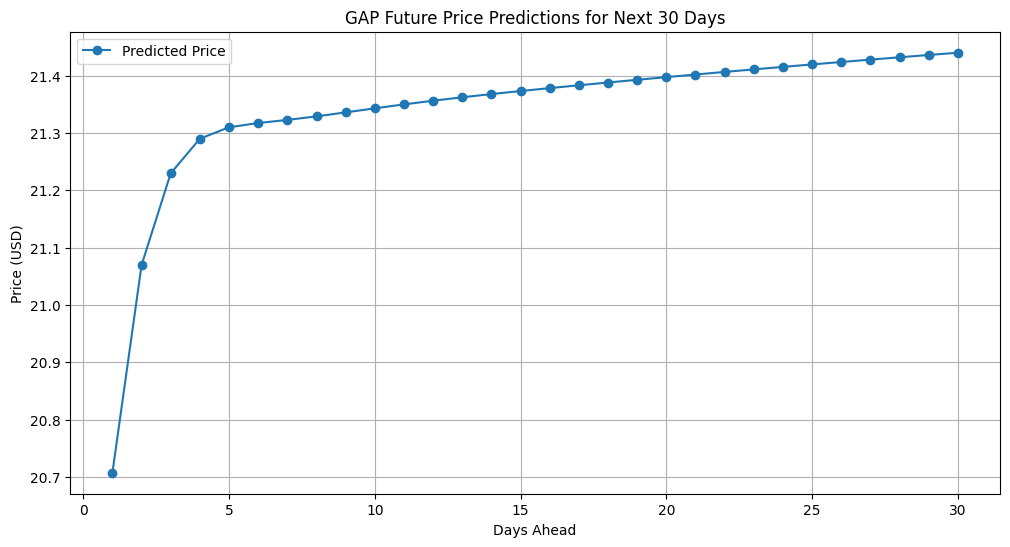

In [19]:
import matplotlib.pyplot as plt

# Create an array for the x-axis representing each future day (1 to future_steps)
future_days = np.arange(1, future_steps + 1)

# Plot the predicted future values
plt.figure(figsize=(12, 6))
plt.plot(future_days, future_predictions_unscaled, marker='o', linestyle='-', label='Predicted Price')
plt.title("GAP Future Price Predictions for Next 30 Days")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Code for cross validation

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Set up TimeSeriesSplit for cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# List to store validation loss for each fold
val_losses = []

# Loop through each split of the training data
for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Training fold {fold+1}")
    
    # Split the data into current fold's training and validation sets
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Create a new model instance for each fold
    model_cv = tuner.hypermodel.build(best_hps)
    
    # Setup EarlyStopping to monitor validation loss for the current fold
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model on the current fold's training data
    history_cv = model_cv.fit(
        X_train_cv, y_train_cv,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[early_stop],
        verbose=0  # Set verbose to 0 to reduce output clutter; change to 1 for more details
    )
    
    # Evaluate the model on the current fold's validation data
    fold_val_loss = model_cv.evaluate(X_val_cv, y_val_cv, verbose=0)
    print(f"Fold {fold+1} Validation Loss: {fold_val_loss}")
    val_losses.append(fold_val_loss)

# Calculate the average validation loss across all folds
average_val_loss = np.mean(val_losses)
print("Cross-validation validation losses:", val_losses)
print("Average validation loss:", average_val_loss)

Training fold 1
Fold 1 Validation Loss: 0.0031107456889003515
Training fold 2
Fold 2 Validation Loss: 0.001366868382319808
Training fold 3
Fold 3 Validation Loss: 0.0006687380373477936
Training fold 4
Fold 4 Validation Loss: 0.0002058839745586738
Training fold 5
Fold 5 Validation Loss: 0.0006966618238948286
Cross-validation validation losses: [0.0031107456889003515, 0.001366868382319808, 0.0006687380373477936, 0.0002058839745586738, 0.0006966618238948286]
Average validation loss: 0.001209779581404291


## the average validation loss is significantly better than that of Model 1, proving success in our hyper-parameter tuning

# Managment Question
## In layman’s terms, what is the management/research question of interest, and why would anyone care?  This week the question is very important and it requires in depth research. 

The fundamental question we want to answer is: **Can deep learning models, specifically RNN-LSTM architectures, be optimized to effectively forecast stock prices with minimal lag, and how can this impact decision-making in financial markets and outside of financial markets?** This question is critical because financial markets are highly volatile, and even a slight edge in forecasting accuracy can translate into substantial profits or losses. Traditional statistical models like ARIMA often fail to capture intricate patterns in stock prices, especially short-term fluctuations influenced by real-time market sentiment, global events, and algorithmic trading. By leveraging deep learning, particularly an optimized LSTM model, we aim to bridge this gap by reducing the lag in predictions and increasing precision. The key challenge is not just predicting general upward or downward trends but also capturing small yet significant fluctuations that traders rely on for making informed decisions. If such a model can consistently provide real-time, high-accuracy predictions, it can become a valuable tool for hedge funds, institutional investors, and even retail traders looking to optimize their trading strategies.  

Beyond just trading, this study has broader implications in risk management, portfolio optimization, and automated investment strategies. Large financial institutions, such as banks and hedge funds, could integrate an optimized LSTM model into their high-frequency trading (HFT) algorithms to improve trade execution timing. Portfolio managers could use it to identify potential market downturns before they occur, allowing for proactive adjustments to asset allocations. Retail investors, often at a disadvantage against institutions with advanced analytics, could benefit from accessible AI-driven models that provide more precise forecasts, leveling the playing field. Furthermore, policymakers could use such models to study market dynamics, detect anomalies, and mitigate the risks of market crashes. The ability to forecast market movements accurately is not just a tool for profit but also a mechanism for maintaining financial stability.  

Optimizing LSTM models for stock price forecasting requires careful tuning of hyperparameters, as demonstrated in our project. Our results show that a well-tuned model significantly outperforms a baseline model, reducing prediction lag and improving accuracy. This highlights the importance of hyperparameter optimization techniques, such as Keras Tuner, in refining deep learning models for time-series forecasting. Additionally, integrating external data sources, such as news sentiment analysis, social media trends, and macroeconomic indicators, could further enhance predictive performance. While LSTMs are powerful, their sequential nature sometimes leads to long-term dependency issues, which could be mitigated using hybrid models that incorporate attention mechanisms or Transformer architectures. The continuous evolution of AI in financial forecasting suggests that businesses willing to invest in cutting-edge deep learning research will gain a substantial competitive advantage.  

The significance of this project extends beyond financial markets into industries where time-sensitive predictions are crucial. In supply chain management, for example, reducing forecasting lag can help businesses respond faster to demand changes, minimizing excess inventory costs and preventing shortages. In healthcare, LSTM models can improve early diagnosis by identifying subtle trends in patient data, allowing for timely medical interventions. Even in climate science, optimizing time-series models can lead to more accurate weather predictions, improving disaster preparedness and resource allocation. The business value of predictive models that minimize lag is significant, as they enhance efficiency, reduce costs, and improve decision-making across various industries. By continuously refining these models, we move closer to real-time AI-driven forecasting that has tangible, real-world impact.


# Reference

Partial code provided by MSDS 422: Practical Machine Learning, curriculum by Northwestern University School of Professional Studies

Yahoo Finance. 2025. GAP stock prices (5 years). 
- https://finance.yahoo.com

O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca, et al. 2019. KerasTuner. 
- https://github.com/keras-team/keras-tuner 

David Olumuyiwa Sunday. 2024. “Application of Long Short-Term Memory (LSTM) in Stock 
Price Prediction”. International Journal of Development and Economic Sustainability. 
Vol.12, No.3, pp.36-45. June 19, 2024. 
- https://doi.org/10.37745/ijdes.13/vol12n33645 

Fausto Ricchiuti, Giancarlo Sperlí. 2025. “An Advisor Neural Network framework using 
LSTM-based Informative Stock Analysis”. Expert Systems with Applications. Vol. 259. 
January 1, 2025. 
- https://doi.org/10.1016/j.eswa.2024.125299 